# AV WNS Analytics Wizard 2019 Hackathon

Analytics Vidhya - Click Prediction Analysis in Python using sklearn package

https://satya-python.blogspot.com/

Jupyter Notebook in Google Colab

In [0]:
# Importing required packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA

# Loading Data

In [2]:
from google.colab import files,drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Analytics\ Vidhya/wns-analytics-wizard-2019

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Analytics Vidhya/wns-analytics-wizard-2019


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
item_data = pd.read_csv("item_data.csv")
view_log = pd.read_csv("view_log.csv")

test_imp_ids = test["impression_id"]

# EDA - Exploratory Data Analysis

In [4]:
# Check number of features and data points in train and test
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 237609
Number of features in train: 7
Number of data points in test: 90675
Number of features in test: 6


In [5]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [6]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [7]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [8]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [0]:
train['impression_time'] = pd.to_datetime(train['impression_time'])
test['impression_time'] = pd.to_datetime(test['impression_time'])

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null datetime64[ns]
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 12.7+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 6 columns):
impression_id      90675 non-null object
impression_time    90675 non-null datetime64[ns]
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.2+ MB


In [12]:
item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Data columns (total 6 columns):
item_id         132761 non-null int64
item_price      132761 non-null int64
category_1      132761 non-null int64
category_2      132761 non-null int64
category_3      132761 non-null int64
product_type    132761 non-null int64
dtypes: int64(6)
memory usage: 6.1 MB


In [13]:
view_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
server_time    object
device_type    object
session_id     int64
user_id        int64
item_id        int64
dtypes: int64(3), object(2)
memory usage: 119.0+ MB


In [14]:
# Checking for NULL/missing values
train.isnull().sum()

impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64

In [15]:
view_log.isnull().sum()

server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64

0    226747
1     10862
Name: is_click, dtype: int64
0    95.428624
1     4.571376
Name: is_click, dtype: float64



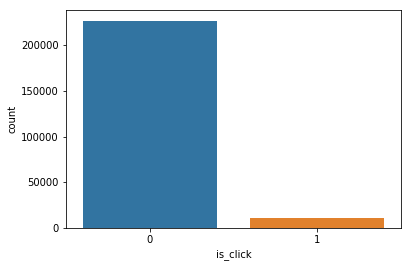

In [16]:
print(train['is_click'].value_counts())
print(train['is_click'].value_counts(normalize=True)*100)
print()
sns.countplot(train["is_click"])

In [17]:
train.is_4G.value_counts().sort_index()

0    151758
1     85851
Name: is_4G, dtype: int64

In [18]:
train.os_version.value_counts().sort_index()

intermediate     55543
latest          129216
old              52850
Name: os_version, dtype: int64

In [19]:
train.app_code.describe()

count    237609.000000
mean        249.099971
std         135.213609
min           0.000000
25%         163.000000
50%         213.000000
75%         385.000000
max         522.000000
Name: app_code, dtype: float64

In [20]:
train.user_id.describe()

count    237609.000000
mean      46454.526828
std       26802.726666
min           0.000000
25%       23197.000000
50%       46597.000000
75%       69684.000000
max       92586.000000
Name: user_id, dtype: float64

In [0]:
train['impression_time_quarter'] = train['impression_time'].dt.quarter
train['impression_time_month'] = train['impression_time'].dt.month
train['impression_time_day'] = train['impression_time'].dt.day
train['impression_time_dayofweek'] = train['impression_time'].dt.dayofweek
train['impression_time_weekday'] = train['impression_time'].dt.weekday_name
train['impression_time_is_weekend'] = np.where(train['impression_time'].dt.dayofweek.isin(['Sunday', 'Saturday']), 1,0)

test['impression_time_quarter'] = test['impression_time'].dt.quarter
test['impression_time_month'] = test['impression_time'].dt.month
test['impression_time_day'] = test['impression_time'].dt.day
test['impression_time_dayofweek'] = test['impression_time'].dt.dayofweek
test['impression_time_weekday'] = test['impression_time'].dt.weekday_name
test['impression_time_is_weekend'] = np.where(test['impression_time'].dt.dayofweek.isin(['Sunday', 'Saturday']), 1,0)

In [26]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impression_time_quarter,impression_time_day,impression_time_dayofweek,impression_time_weekday,impression_time_is_weekend,impression_time_month
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,4,15,3,Thursday,0,11
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,4,15,3,Thursday,0,11
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,4,15,3,Thursday,0,11
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,4,15,3,Thursday,0,11
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,4,15,3,Thursday,0,11


# Preparing Data

In [0]:
train.drop(["impression_id","impression_time","user_id"], axis=1, inplace=True)
test.drop(["impression_id","impression_time","user_id"], axis=1, inplace=True)

In [28]:
str_cols= train.loc[:, train.dtypes=='object'].columns.tolist()
str_cols

['os_version', 'impression_time_weekday']

In [29]:
train.sample(5)

,app_code,os_version,is_4G,is_click,impression_time_quarter,impression_time_day,impression_time_dayofweek,impression_time_weekday,impression_time_is_weekend,impression_time_month
21455,207,latest,1,0,4,20,1,Tuesday,0,11
105580,436,latest,0,0,4,30,4,Friday,0,11
57260,207,old,1,0,4,24,5,Saturday,0,11
163000,190,latest,0,0,4,1,5,Saturday,0,12
106117,5,latest,0,0,4,26,0,Monday,0,11


In [30]:
test.sample(5)

,app_code,os_version,is_4G,impression_time_quarter,impression_time_day,impression_time_dayofweek,impression_time_weekday,impression_time_is_weekend,impression_time_month
85503,410,old,0,4,18,1,Tuesday,0,12
24108,392,old,0,4,13,3,Thursday,0,12
37481,169,intermediate,1,4,14,4,Friday,0,12
37390,190,intermediate,1,4,14,4,Friday,0,12
42377,38,latest,1,4,14,4,Friday,0,12


In [31]:
# # Correlations between Features and Target

# Find all correlations and sort 
correlations_data = train.corr()['is_click'].sort_values()

# most negative correlations
print(correlations_data.head(10))
print()

# most positive correlations
print(correlations_data.tail(10))

impression_time_day          -0.005490
app_code                     -0.005449
is_4G                        -0.003464
impression_time_month         0.002918
impression_time_dayofweek     0.005079
is_click                      1.000000
impression_time_quarter            NaN
impression_time_is_weekend         NaN
Name: is_click, dtype: float64

impression_time_day          -0.005490
app_code                     -0.005449
is_4G                        -0.003464
impression_time_month         0.002918
impression_time_dayofweek     0.005079
is_click                      1.000000
impression_time_quarter            NaN
impression_time_is_weekend         NaN
Name: is_click, dtype: float64


In [0]:
# One Hot Encoding
train = pd.get_dummies(train, columns=str_cols, drop_first=True)
test = pd.get_dummies(test, columns=str_cols, drop_first=True)

In [33]:
train.sample(5)

,app_code,is_4G,is_click,impression_time_quarter,impression_time_day,impression_time_dayofweek,impression_time_is_weekend,impression_time_month,os_version_latest,os_version_old,impression_time_weekday_Monday,impression_time_weekday_Saturday,impression_time_weekday_Sunday,impression_time_weekday_Thursday,impression_time_weekday_Tuesday,impression_time_weekday_Wednesday
2920,32,0,0,4,15,3,0,11,1,0,0,0,0,1,0,0
68740,244,1,0,4,21,2,0,11,1,0,0,0,0,0,0,1
72319,44,0,0,4,21,2,0,11,1,0,0,0,0,0,0,1
103991,190,0,1,4,27,1,0,11,0,0,0,0,0,0,1,0
228603,5,0,0,4,10,0,0,12,0,0,1,0,0,0,0,0


In [34]:
train2 = train.drop(['is_click'], axis=1)
target = train["is_click"]
print(train['is_click'].value_counts(normalize=True)*100)
print("\n train2 shape:", train2.shape)

0    95.428624
1     4.571376
Name: is_click, dtype: float64

 train2 shape: (237609, 15)


In [0]:
train2 = train2.loc[:, test.columns]

In [36]:
train2.head()

,app_code,is_4G,impression_time_quarter,impression_time_day,impression_time_dayofweek,impression_time_is_weekend,impression_time_month,os_version_latest,os_version_old,impression_time_weekday_Monday,impression_time_weekday_Saturday,impression_time_weekday_Sunday,impression_time_weekday_Thursday,impression_time_weekday_Tuesday,impression_time_weekday_Wednesday
0,422,0,4,15,3,0,11,0,1,0,0,0,1,0,0
1,467,1,4,15,3,0,11,1,0,0,0,0,1,0,0
2,259,1,4,15,3,0,11,0,0,0,0,0,1,0,0
3,244,1,4,15,3,0,11,1,0,0,0,0,1,0,0
4,473,0,4,15,3,0,11,1,0,0,0,0,1,0,0


In [37]:
target.head()

0    0
1    1
2    0
3    0
4    0
Name: is_click, dtype: int64

In [0]:
scaler = StandardScaler()
train2 = scaler.fit_transform(train2)
test = scaler.transform(test)

In [39]:
poly = PolynomialFeatures(degree=2)
train2 = poly.fit_transform(train2)
test = poly.transform(test)

print("train2 shape:", train2.shape)

train2 shape: (237609, 136)


In [40]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=123)
print(x_train.shape, x_val.shape)

(166326, 136) (71283, 136)


In [41]:
x_train

array([[ 1.        ,  1.0124744 , -0.75213688, ...,  0.22691996,
         0.1838242 ,  0.14891302],
       [ 1.        , -0.88822586, -0.75213688, ...,  0.22691996,
        -1.23444007,  6.71532942],
       [ 1.        , -0.0525094 , -0.75213688, ...,  0.22691996,
         0.1838242 ,  0.14891302],
       ...,
       [ 1.        , -1.60561078,  1.32954524, ...,  4.40684021,
        -0.81008388,  0.14891302],
       [ 1.        ,  0.90153858, -0.75213688, ...,  0.22691996,
         0.1838242 ,  0.14891302],
       [ 1.        , -0.31135963, -0.75213688, ...,  0.22691996,
         0.1838242 ,  0.14891302]])

# ML

In [42]:
# Logistic Regression
for c in [0.1, 1, 5, 100]:
    lr = LogisticRegression(random_state=2019, C=c).fit(x_train, y_train)
    print ("roc_auc_score for C=%s: %s" % (c, roc_auc_score(y_val, lr.predict(x_val))))

roc_auc_score for C=0.1: 0.5
roc_auc_score for C=1: 0.5
roc_auc_score for C=5: 0.5
roc_auc_score for C=100: 0.5


In [43]:
clf_log = LogisticRegression(random_state=2019).fit(x_train, y_train)
clf_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2019, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_val = clf_log.predict(x_val)

Text(33.0, 0.5, 'Predicted Label')

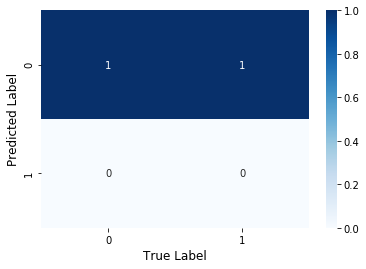

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

In [46]:
clf_log.fit(train2, target)
y_pred = clf_log.predict(test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
submission = {}
submission['impression_id'] = test_imp_ids
submission['is_click'] = y_pred
submission = pd.DataFrame(submission)
submission = submission[['impression_id', 'is_click']]
submission.to_csv("submission.csv", index=False)
print(submission['is_click'].value_counts())

0    90675
Name: is_click, dtype: int64


In [48]:
!pwd; ls -ltr

/content/drive/My Drive/Analytics Vidhya/wns-analytics-wizard-2019
total 173209
-rw------- 1 root root   6567193 Aug 24 04:07 test.csv
-rw------- 1 root root   3346472 Aug 24 04:07 item_data.csv
-rw------- 1 root root  17681346 Aug 24 04:07 train.csv
-rw------- 1 root root 146595750 Aug 24 04:12 view_log.csv
-rw------- 1 root root   3173648 Aug 24 10:42 submission.csv


In [0]:
files.download('submission.csv')